In [1]:
from sklearn.datasets import make_classification, make_gaussian_quantiles, make_moons, make_circles

n_samples = 500
datasets = {
    'Linearly Separable': make_classification(n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42),
    'Moons': make_moons(n_samples=n_samples, noise=0.3, random_state=42),
    'Circles': make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=42),
    'Gaussian Quantiles': make_gaussian_quantiles(n_samples=n_samples, n_features=2, n_classes=3, random_state=42),
}

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

def nb_model_params():
    return GaussianNB(), {}


def knn_model_params():
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev']
    }
    return KNeighborsClassifier(), param_grid


def svm_model_params():
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
    }
    return SVC(kernel='rbf', random_state=42), param_grid


def dt_model_params():
    param_grid = {
        'max_depth': [3, 5, 7, 9, 11],
        'min_samples_split': [2, 4, 6, 8, 10],
        'min_samples_leaf': [1, 2, 3, 4, 5]
    }
    return DecisionTreeClassifier(random_state=42), param_grid


def xgb_model_params():
    param_grid = {
        'max_depth': [3, 5, 7, 9, 11],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'n_estimators': [50, 100, 200, 300]
    }
    return XGBClassifier(random_state=42), param_grid


def nn_model_params():
    param_grid = {
        'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
    }
    return  MLPClassifier(max_iter=1000, random_state=42), param_grid


classifiers = {
    'Naive Bayes': nb_model_params(),
    'KNN': knn_model_params(),
    'RBF SVM': svm_model_params(),
    'Decision Tree': dt_model_params(),
    'XGBoost': xgb_model_params(),
    'Neural Net': nn_model_params(),
}

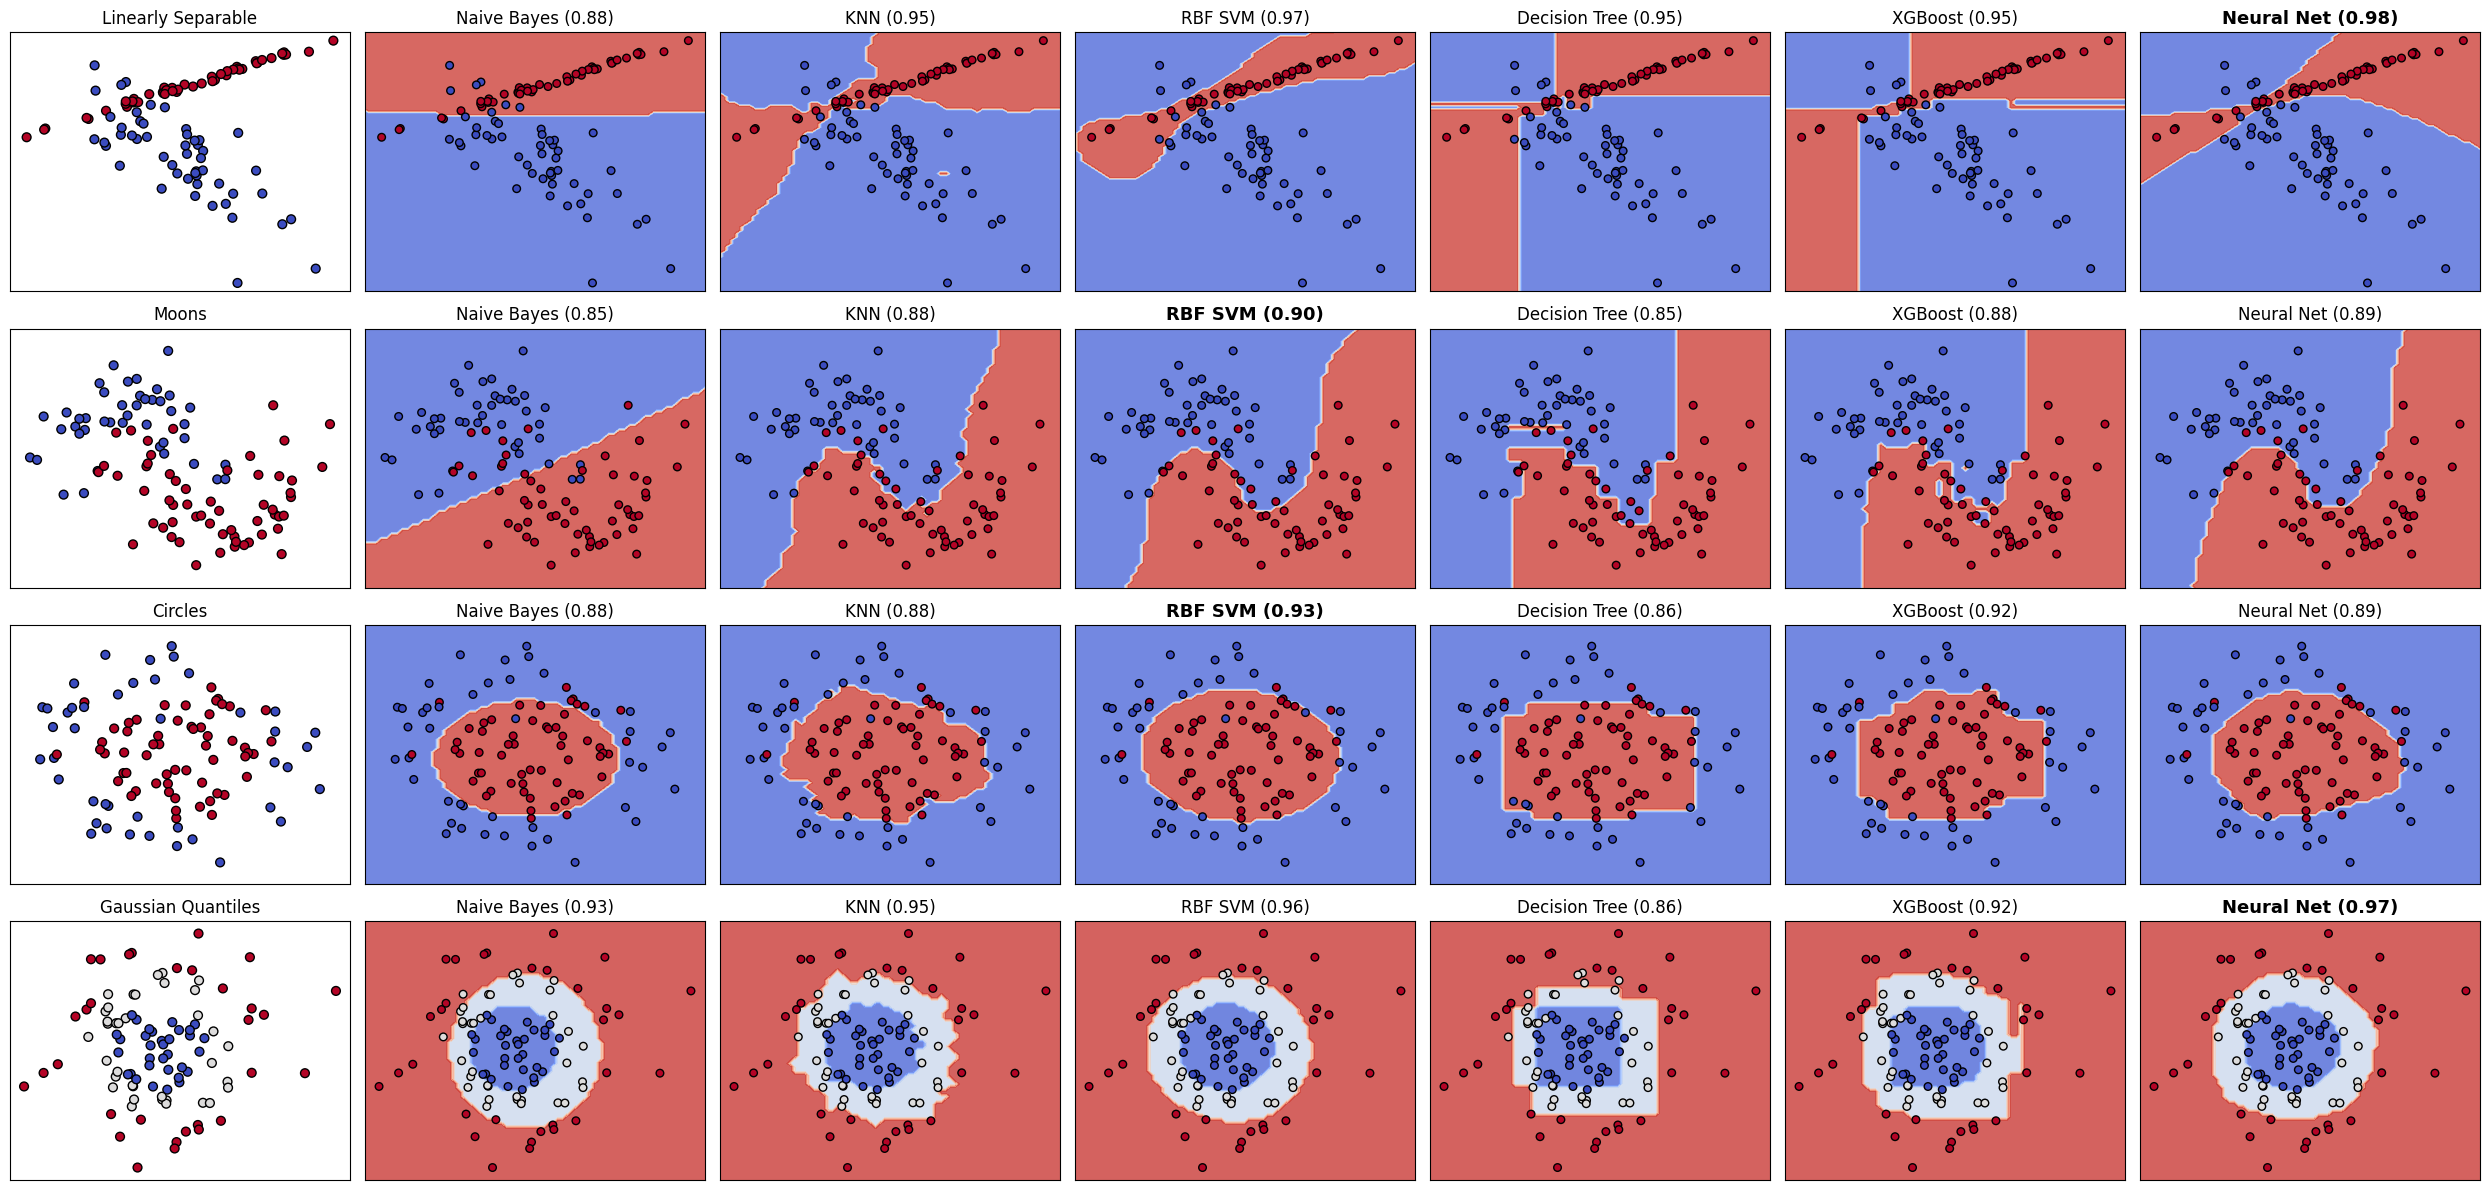

In [3]:
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

i = 1
figure = plt.figure(figsize=(25, 12))
for ds_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    x_min, x_max = X_test[:, 0].min() - .25, X_test[:, 0].max() + .25
    y_min, y_max = X_test[:, 1].min() - .25, X_test[:, 1].max() + .25

    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap='coolwarm', s=40)
    ax.set_title(ds_name)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    best_score = 0
    best_name = None
    best_plot_index = None
    optimal_model_params = {}
    for name, (clf, param_grid) in classifiers.items():
        param_grid = {f'{clf.__class__.__name__.lower()}__{key}': value for key, value in param_grid.items()}

        pipe = make_pipeline(StandardScaler(), clf)
        grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        score = grid.score(X_test, y_test)
        optimal_model_params[name] = grid.best_params_
        
        if score > best_score:
            best_score = score
            best_name = name
            best_plot_index = i

        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        DecisionBoundaryDisplay.from_estimator(grid, X, ax=ax, cmap='coolwarm', alpha=0.8, plot_method='contourf', response_method='predict')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap='coolwarm', s=30)
        ax.set_title(f"{name} ({score:.2f})")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1
    
    ax = plt.subplot(len(datasets), len(classifiers) + 1, best_plot_index)
    ax.set_title(f"{best_name} ({best_score:.2f})", fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig('output/output-classification.png', bbox_inches='tight')

In [4]:
for name, params in optimal_model_params.items():
    params = {key.split('__')[1]: value for key, value in params.items()}
    params = ', '.join([f'{key} = {value}' for key, value in params.items()])
    print(f'{name}: {params}')

Naive Bayes: 
KNN: metric = chebyshev, n_neighbors = 3, weights = distance
RBF SVM: C = 100, gamma = 0.1
Decision Tree: max_depth = 11, min_samples_leaf = 1, min_samples_split = 10
XGBoost: learning_rate = 0.1, max_depth = 9, n_estimators = 50
Neural Net: activation = relu, alpha = 0.0001, hidden_layer_sizes = (25, 25, 25)
